# Regridding the SeaWIFS [Chl] onto the ASTE grid

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Get the datasets

### [Chl] climatology

In [2]:
chl_dir = '/local/data/artemis/workspace/rdussin/Observations/SeaWIFS/'
chl_ds = xr.open_mfdataset(chl_dir + 'SeaWIFS_Chla_OCI_clim_m??.nc')

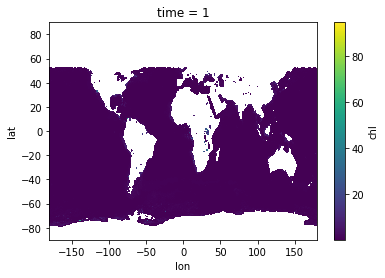

In [3]:
chl_ds['chl'].isel(time=0).plot()

In [4]:
chl_ds

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320, time: 12)
Coordinates:
  * lon      (lon) float32 -179.95833 -179.875 -179.79166 -179.70833 ...
  * lat      (lat) float32 -89.958336 -89.87501 -89.791664 -89.708336 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    chl      (time, lat, lon) float32 dask.array<shape=(12, 2160, 4320), chunksize=(1, 2160, 4320)>

### ASTE raw grid

In [5]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

## Regridding

The mld fields are not gonna be used to force the model so no extrapolation is needed.
Those are 2d fields so no vertical interpolation either

In [11]:
chl_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(chl_ds, aste_raw, ['chl'], 
                                                         method='bilinear',
                                                         lonname='lon', latname='lat', point='T', 
                                                         periodic=True, reuse_weights=False)

Reuse existing file: regrid_face0.nc
Reuse existing file: regrid_face1.nc
Reuse existing file: regrid_face2.nc
Reuse existing file: regrid_face3.nc
Reuse existing file: regrid_face4.nc
Reuse existing file: regrid_face5.nc


## Checking the results

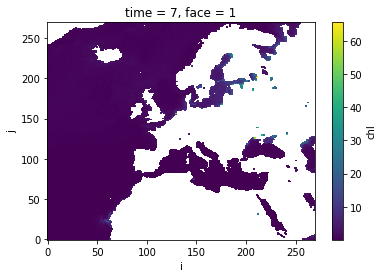

In [15]:
chl_aste.chl.isel(face=1, time=6).plot()

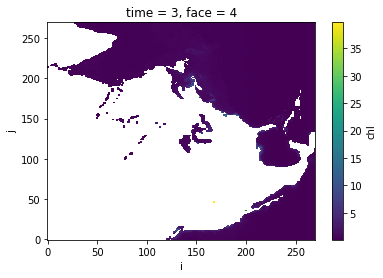

In [16]:
chl_aste.chl.isel(face=4, time=2).plot()

## Write to netcdf file

In [18]:
chl_aste['time'] = xr.DataArray(np.arange(12), dims=['time'], attrs={'units':'months since 1900-01-15 0:00:00'})
chl_aste = chl_aste.transpose(*('time','face','j','i'))
chl_aste.to_netcdf(chl_dir + '/interp_ASTE/' + 'clim_Chl_SeaWIFS_ASTE.nc', unlimited_dims='time')